This notebook was used to visualize conditional averages in the lower-order manifold spanned by and snapshots of the first two leading PC's of a principal component analysis on the large-scale variables


In [1]:
## import some packages 

import xarray as xr
import numpy as np
import math
import scipy as sc
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs

import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as plb
import matplotlib.image as imag


import pickle

In [2]:
## setting a few formatting options for the plots 

fz = 18 # default fontsize
lw = 4 # default linewidth
siz = 100

plt.rc('text', usetex=False)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw



In [3]:
#loading the output normalization scalars for SP variables ( stds over 3 months of SP simulation)
import pandas as ps
from cbrain.imports import *

from cbrain.utils import *
scale_array=ps.read_csv('nn_config/scale_dicts/Scaling_cond_VAE.csv')


PHQ_std_surf=scale_array.PHQ_std.values[-1]

TPHYSTND_std_23=scale_array.TPHYSTND_std.values[-1]# for dT/dt we are using the std on level 23 ~ 845 hPa

PRECT_std=scale_array.PRECT_std.values
FSNS_std=scale_array.FSNS_std.values
FSNT_std=scale_array.FSNT_std.values
FLNS_std=scale_array.FLNS_std.values
FLNT_std=scale_array.FLNT_std.values

# and the CAM variables 
scale_array_2D=ps.read_csv('nn_config/scale_dicts/Scaling_enc_II_range_profiles.csv')
scale_array_1D=ps.read_csv('nn_config/scale_dicts/Scaling_enc_II_range.csv')

TBP_std_surf=scale_array_2D.TBP_std.values[-1]

QBP_std_surf=scale_array_2D.QBP_std.values[-1]

Q_lat_std_surf=scale_array_1D.Q_lat_std.values

Q_sens_std_surf=scale_array_1D.Q_sens_std.values


Q_solar_std_surf=scale_array_1D.Q_sol_std.values

PS_std_surf=scale_array_1D.PS_std.values


# defining the scaling dict for the VAE training 

scale_dict_II = {
    'PHQ': 1/PHQ_std_surf, 
    'QBP':1/QBP_std_surf,
    'TPHYSTND': 1/TPHYSTND_std_23, 
    'TBP':1/TBP_std_surf,
    'FSNT': 1/FSNT_std, 
    'FSNS': 1/FSNS_std, 
    'FLNT': 1/FLNT_std, 
    'FLNS': 1/FLNS_std, 
    'PRECT': 1/PRECT_std, 
    'LHFLX': 1/Q_lat_std_surf, 
    'SHFLX': 1/Q_sens_std_surf, 
    'SOLIN': 1/Q_solar_std_surf,
    'PS':1/PS_std_surf
}

in_vars = ['QBP', 'TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX']
out_vars = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS', 'PRECT','QBP', 'TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX']

In [4]:
from cbrain.data_generator import DataGenerator
# use of the test data set again
val_gen_II = DataGenerator(
    data_fn = '../preprocessed_data/1918_train_3_month_OND.nc',
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = '../preprocessed_data/000_norm_1_month.nc',
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict_II,
    batch_size=8192,
    shuffle=True
)


# time steps of test data set 
time=4415




In [5]:
lon=np.arange(-180, 180, 360/128)
lat=np.arange(-90, 90, 180/64)

In [6]:

input_lat_data= np.nan* np.zeros((time,int(lat.size *lon.size),64))
for i in tqdm(np.arange(time)):
    input_lat_data[i]=val_gen_II[i][0]   

input_resp_=np.reshape(input_lat_data,(int(time*lat.size*lon.size),64))
del input_lat_data

<ipython-input-6-3336a42f73e5>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(np.arange(time)):


In [7]:
from sklearn.decomposition import PCA

input_pca=PCA(n_components=2).fit_transform(input_resp_)


In [8]:
# Based on https://stackoverflow.com/questions/2413522/weighted-standard-deviation-in-np
def weighted_avg_and_std(values, weights,glob_mean):
    """
    author: Gunnar Behrens 
    Return the weighted average, standard deviation, and 
    anomaly to noise ratio (cond_average - global_mean)/cond_std.
    values, weights -- np ndarrays with the same shape.
    
    set np.nan flags for single-values or constant values in grid cells (variance==0)
    """
    
#    print(weights.sum())
    if weights.sum()>0:
        average = np.average(values, weights=weights) # compute grid-cell average
        variance = np.average((values-average)**2, weights=weights)# and variance

        if variance>0:
            anomal_std_ratio=(average-glob_mean)/np.sqrt(variance)
            
        if variance==0:
            
            anomal_std_ratio=np.nan
            
        
        return (average, np.sqrt(variance),anomal_std_ratio)
    if  weights.sum()==0:
        
        average = np.nan
        variance =np.nan
        anomal_std_ratio=np.nan
        
        return (average, np.sqrt(variance),anomal_std_ratio)
        
        

# Make function to calculate conditional mean and std
# We condition field_y on field_x
def conditional_avg_and_std(y_bin_edges,x_bin_edges,field_x,field_y,global_mean_y):
    """
    produce conditional average and std fields for 2D PCA compressed latent space
    """
    # Initialization
    Nbin = np.size(x_bin_edges)
    Ym = np.zeros((Nbin-1,Nbin-1))
    Ystd = np.copy(Ym)
    Yanomaly_std_ratio=np.copy(Ym)
    edge_left=x_bin_edges[0]
    y_edge_bottom=y_bin_edges[0]
    for jbin,y_edge in enumerate(y_bin_edges):
        print('jbin=',jbin,'/',Nbin-1,' & edge=',y_edge,end="\r")

        for ibin,edge in enumerate(x_bin_edges):
#            print('ibin=',ibin,'/',Nbin-1,' & edge=',edge,end="\r")
            if jbin>0:
                if ibin>0:
                    w = ((field_x[:,0]>=edge_left)&(field_x[:,0]<edge))&((field_x[:,1]>=y_edge_bottom)&(field_x[:,1]<y_edge))
                    #print(w.shape)
                    Ym[jbin-1,ibin-1],Ystd[jbin-1,ibin-1],Yanomaly_std_ratio[jbin-1,ibin-1] = weighted_avg_and_std(field_y,w,global_mean_y)

            edge_left = edge
        y_edge_bottom=y_edge
    
    return Ym,Ystd,Yanomaly_std_ratio

In [9]:
rand_no=1000000
rand_sample=np.random.randint(0,input_pca[:,0].size,rand_no)


In [10]:
def field_cond_figure_1(Bin_size_x_and_y,rand_sample,lat_pca_space,SPCAM_var,scaling_factor,
                      title,var_min,var_max,std_var_min,std_var_max,ano_std_rat_min,ano_std_rat_max,
                      color_map,color_map_2,color_map_3):
    """
    author: Gunnar Behrens
    retrieve conditional averages and plot with predefined random samples
    
    Number = Number of random sampling 
    scaling factor = scale to specific SPCAM units 
    """
    
    import matplotlib as mpl
    
    rand_samples=rand_sample # use predefined random samples 
    rand_SPCAM=SPCAM_var[rand_samples]
    rand_encoder_pca_model_data=lat_pca_space[rand_samples]
 
    yy=np.linspace(np.min(lat_pca_space[:,1]),np.max(lat_pca_space[:,1]),Bin_size_x_and_y)
    xx=np.linspace(np.min(lat_pca_space[:,0]),np.max(lat_pca_space[:,0]),Bin_size_x_and_y)
    
    global_mean=np.squeeze(np.mean(SPCAM_var)*scaling_factor)# apply scaling to specific unit and compute mean of SP var
    print(global_mean) # return overall variable mean 
    # compute cond. means , stds and anomaly to stds ratio
    a,b,c=conditional_avg_and_std(yy,xx,rand_encoder_pca_model_data,rand_SPCAM*scaling_factor,global_mean)
    
    
    #plt.figure(1,(7,7))
    #plt.pcolormesh(xx,yy,a,cmap=color_map)
    #plt.grid(True)
    #plt.title(title + 'mean',Fontsize=14)
    #plt.xlabel('PC 1 of latent space',Fontsize=13)
    #plt.ylabel('PC 2 of latent space',Fontsize=13)
    #plt.clim(var_min,var_max)
    #plt.colorbar()
    
    #plt.figure(2,(7,7))
    #plt.pcolormesh(xx,yy,b,cmap=color_map_2)
    #plt.grid(True)
    #plt.title(title + 'std',Fontsize=14)
    #plt.xlabel('PC 1 of latent space',Fontsize=13)
    #plt.ylabel('PC 2 of latent space',Fontsize=13)
    #plt.clim(std_var_min,std_var_max)
    #plt.colorbar()
    
    #plt.figure(3,(7,7))
    #plt.pcolormesh(xx,yy,c,cmap=color_map_3)
    #plt.grid(True)
    #plt.title(title + 'signal to noise ratio',Fontsize=14)
    #plt.xlabel('PC 1 of latent space',Fontsize=13)
    #plt.ylabel('PC 2 of latent space',Fontsize=13)
    #plt.clim(ano_std_rat_min,ano_std_rat_max)
    #plt.colorbar()
    
    
    
    
    return a,xx,yy
    
    
                      

In [8]:
precip=np.nan*np.zeros((time,int(lat.size*lon.size)))
for i in tqdm(np.arange(time)):
    precip[i]=val_gen_II.output_transform.inverse_transform(val_gen_II[i][1])[:,64]


<ipython-input-8-dd49448511e7>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(np.arange(time)):


In [9]:
precip_=np.reshape(precip,int(time*lat.size*lon.size))
del precip

In [10]:
precipitation,xx,yy=field_cond_figure_1(50,rand_sample,input_pca,precip_,1000*3600,'PCA precipitation [mm/h] '
                  ,0,8,0,3,-5,5,plt.cm.gist_stern,plt.cm.gist_stern,plt.cm.twilight_shifted)

NameError: name 'field_cond_figure_1' is not defined

In [11]:
SOLIN=np.nan*np.zeros((time,int(lat.size*lon.size)))
for i in tqdm(np.arange(time)):
    SOLIN[i]=val_gen_II.output_transform.inverse_transform(val_gen_II[i][1])[:,126]


<ipython-input-11-cb3f89cda84b>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(np.arange(time)):


In [12]:
SOLIN_resh=np.reshape(SOLIN,int(time*lat.size*lon.size))
del SOLIN

In [13]:
Q_sw_top=np.nan*np.zeros((time,int(lat.size*lon.size)))
for i in tqdm(np.arange(time)):
    Q_sw_top[i]=val_gen_II.output_transform.inverse_transform(val_gen_II[i][1])[:,60]


<ipython-input-13-19554c51f6dd>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(np.arange(time)):


In [14]:
Q_sw_top_resh=np.reshape(Q_sw_top,int(time*lat.size*lon.size))
del Q_sw_top

In [15]:
OLR=np.nan*np.zeros((time,int(lat.size*lon.size)))
for i in tqdm(np.arange(time)):
    OLR[i]=val_gen_II.output_transform.inverse_transform(val_gen_II[i][1])[:,62]


<ipython-input-15-ddd237980dfa>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(np.arange(time)):


In [16]:
OLR_resh=np.reshape(OLR,int(time*lat.size*lon.size))

In [17]:
T_surf=np.nan*np.zeros((time,int(lat.size*lon.size)))
for i in tqdm(np.arange(time)):
    T_surf[i]=val_gen_II.output_transform.inverse_transform(val_gen_II[i][1])[:,124]


<ipython-input-17-c893277387e6>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(np.arange(time)):


In [18]:
T_surf_=np.reshape(T_surf,int(time*lat.size*lon.size))
del T_surf

In [22]:
OLR=field_cond_figure_1(50,rand_sample,input_pca,OLR_resh,1,'PCA OLR [W/m²] ',
                  50,320,0,80,-10,10,plt.cm.gist_stern,plt.cm.gist_stern,plt.cm.twilight_shifted)[0]

222.49417578777675


In [23]:
SOLIN=field_cond_figure_1(50,rand_sample,input_pca,SOLIN_resh,1,'PCA solar insolation [W/m²] '
                  ,0,1400,0,700,-20,20,plt.cm.gist_stern,plt.cm.gist_stern,plt.cm.twilight_shifted)[0]

326.0790779369521


In [25]:
Q_SW_TOP=field_cond_figure_1(50,rand_sample,input_pca,Q_sw_top_resh,1,'PCA sw Q_top [W/m²] '
                  ,0,1200,0,500,-20,20,plt.cm.gist_stern,plt.cm.gist_stern,plt.cm.twilight_shifted)[0]

231.61601316221706


In [26]:
T_surf=field_cond_figure_1(50,rand_sample,input_pca,T_surf_,1,'PCA T surf [K] '
                  ,270,303,0,5.5,-20,20,plt.cm.gist_stern,plt.cm.gist_stern,plt.cm.twilight_shifted)[0]

283.69610789159515


In [27]:
##fixed x and y axis + fixed colorrange and reduced number of colorbars
#define few limits for precip, OLR, shortwave heat flux, solar insolation and surface air temperatures  
prec_min=0
prec_max=10
OLR_min=80
OLR_max=300
sw_hf_top_min=0
sw_hf_top_max=1200
SOLIN_min=0
SOLIN_max=1400
T_min=273
T_max=303

#limits of 2D PCA compressed latent space
x_min= -30
x_max= 45
y_min= -20
y_max= 35

# Conditional average plots of PCA on large-scale variables

In [28]:
prec_max_glob=8 #[mm/h] selecting a smaller precip maximum for these global plots 

<ipython-input-29-b523113d0f08>:7: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.title('Solar Insolation '+r'$[\frac{W}{m^2}]$',Fontsize=24)
<ipython-input-29-b523113d0f08>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.ylabel('PC 2', Fontsize=20)
<ipython-input-29-b523113d0f08>:23: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.title('Precipitation '+r'$[\frac{mm}{h}]$',Fontsize=24)
<ipython-input-29-b523113d0f08>:36: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.title('Outgoing Longwave Radiation '+r'$[\frac{W}{m^2}]$',Fontsize=24)
<ipython-input-29-b523113d0f08>:39: MatplotlibDeprecationWarning: Case-insensitive

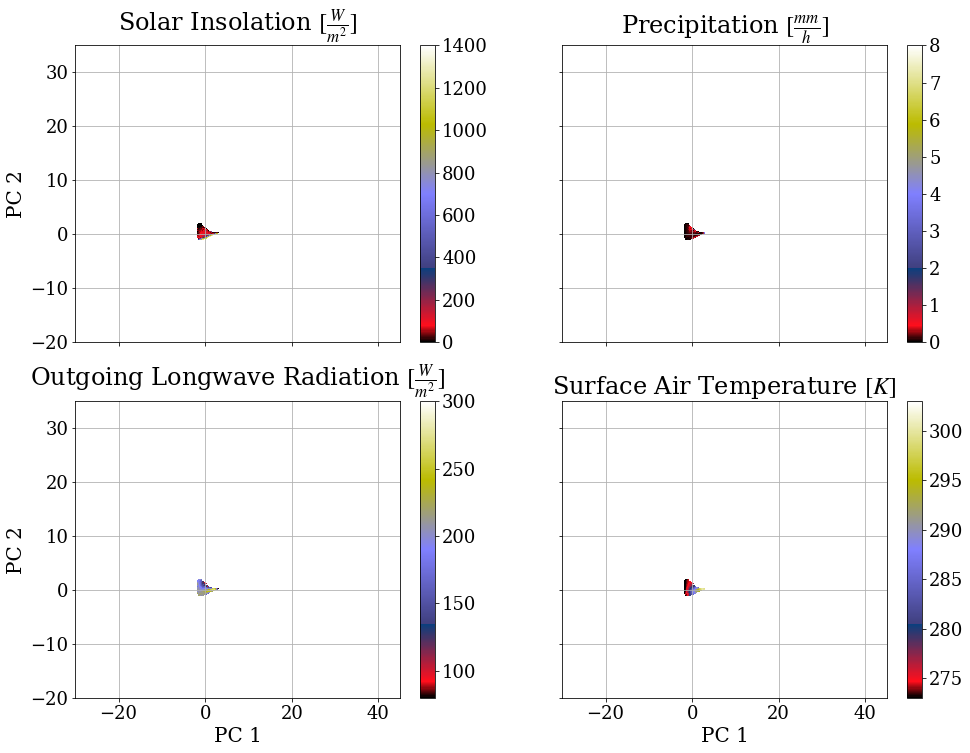

In [29]:
fig = plt.figure(4,(16,12))


ax1 = fig.add_subplot(2,2,1)
imag1=ax1.pcolormesh(xx,yy,SOLIN,cmap=plt.cm.gist_stern)
ax1.grid(True)
plt.title('Solar Insolation '+r'$[\frac{W}{m^2}]$',Fontsize=24)
plt.xlim(x_min,x_max)
plt.ylim(y_min,y_max)
ax1.set_xticklabels([])
plt.ylabel('PC 2', Fontsize=20)
imag1.set_clim(SOLIN_min,SOLIN_max)
plt.colorbar(imag1)






ax2 = fig.add_subplot(2,2,2)
imag2=ax2.pcolormesh(xx,yy,precipitation,cmap=plt.cm.gist_stern)
ax2.grid(True)
plt.title('Precipitation '+r'$[\frac{mm}{h}]$',Fontsize=24)
plt.xlim(x_min,x_max)
plt.ylim(y_min,y_max)
ax2.set_xticklabels([])
ax2.set_yticklabels([])

imag2.set_clim(prec_min,prec_max_glob)

plt.colorbar(imag2)

ax3 = fig.add_subplot(2,2,3)
imag3=ax3.pcolormesh(xx,yy,OLR,cmap=plt.cm.gist_stern)
ax3.grid(True)
plt.title('Outgoing Longwave Radiation '+r'$[\frac{W}{m^2}]$',Fontsize=24)
plt.xlim(x_min,x_max)
plt.ylim(y_min,y_max)
plt.ylabel('PC 2', Fontsize=20)
plt.xlabel('PC 1', Fontsize=20)

imag3.set_clim(OLR_min,OLR_max)
plt.colorbar(imag3)






ax4 = fig.add_subplot(2,2,4)
imag4=ax4.pcolormesh(xx,yy,T_surf,cmap=plt.cm.gist_stern)
ax4.grid(True)
plt.title('Surface Air Temperature '+r'$[K]$',Fontsize=24)
plt.xlim(x_min,x_max)
plt.ylim(y_min,y_max)
ax4.set_yticklabels([])
plt.xlabel('PC 1',Fontsize=20)
imag4.set_clim(T_min,T_max)

plt.colorbar(imag4)





In [30]:
x_min= -5
x_max= 5
y_min= -5
y_max= 5

<ipython-input-31-b523113d0f08>:7: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.title('Solar Insolation '+r'$[\frac{W}{m^2}]$',Fontsize=24)
<ipython-input-31-b523113d0f08>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.ylabel('PC 2', Fontsize=20)
<ipython-input-31-b523113d0f08>:23: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.title('Precipitation '+r'$[\frac{mm}{h}]$',Fontsize=24)
<ipython-input-31-b523113d0f08>:36: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.title('Outgoing Longwave Radiation '+r'$[\frac{W}{m^2}]$',Fontsize=24)
<ipython-input-31-b523113d0f08>:39: MatplotlibDeprecationWarning: Case-insensitive

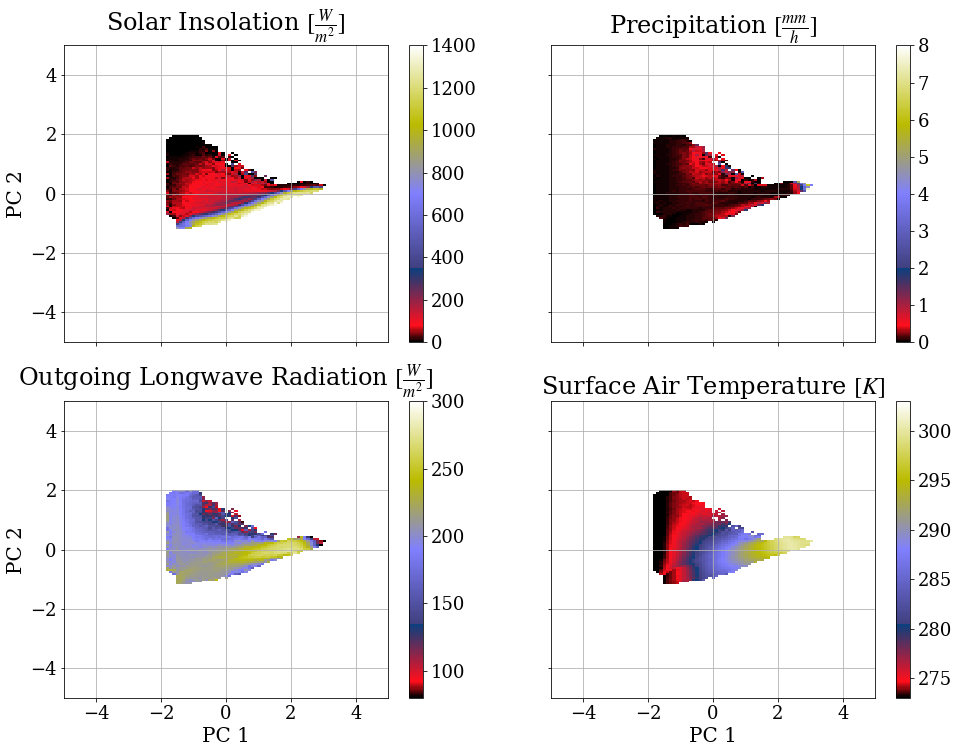

In [31]:
fig = plt.figure(4,(16,12))


ax1 = fig.add_subplot(2,2,1)
imag1=ax1.pcolormesh(xx,yy,SOLIN,cmap=plt.cm.gist_stern)
ax1.grid(True)
plt.title('Solar Insolation '+r'$[\frac{W}{m^2}]$',Fontsize=24)
plt.xlim(x_min,x_max)
plt.ylim(y_min,y_max)
ax1.set_xticklabels([])
plt.ylabel('PC 2', Fontsize=20)
imag1.set_clim(SOLIN_min,SOLIN_max)
plt.colorbar(imag1)






ax2 = fig.add_subplot(2,2,2)
imag2=ax2.pcolormesh(xx,yy,precipitation,cmap=plt.cm.gist_stern)
ax2.grid(True)
plt.title('Precipitation '+r'$[\frac{mm}{h}]$',Fontsize=24)
plt.xlim(x_min,x_max)
plt.ylim(y_min,y_max)
ax2.set_xticklabels([])
ax2.set_yticklabels([])

imag2.set_clim(prec_min,prec_max_glob)

plt.colorbar(imag2)

ax3 = fig.add_subplot(2,2,3)
imag3=ax3.pcolormesh(xx,yy,OLR,cmap=plt.cm.gist_stern)
ax3.grid(True)
plt.title('Outgoing Longwave Radiation '+r'$[\frac{W}{m^2}]$',Fontsize=24)
plt.xlim(x_min,x_max)
plt.ylim(y_min,y_max)
plt.ylabel('PC 2', Fontsize=20)
plt.xlabel('PC 1', Fontsize=20)

imag3.set_clim(OLR_min,OLR_max)
plt.colorbar(imag3)






ax4 = fig.add_subplot(2,2,4)
imag4=ax4.pcolormesh(xx,yy,T_surf,cmap=plt.cm.gist_stern)
ax4.grid(True)
plt.title('Surface Air Temperature '+r'$[K]$',Fontsize=24)
plt.xlim(x_min,x_max)
plt.ylim(y_min,y_max)
ax4.set_yticklabels([])
plt.xlabel('PC 1',Fontsize=20)
imag4.set_clim(T_min,T_max)

plt.colorbar(imag4)





# Snapshots of the PC's vs. large-scale and sub-grid-scale variables

<ipython-input-20-b878e77a68d9>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  imag1=plt.pcolormesh(lon,lat,np.reshape(input_pca[:,0],(time,lat.size,lon.size))[25,:],cmap=plt.cm.gist_stern)
<ipython-input-20-b878e77a68d9>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  imag1=plt.pcolormesh(lon,lat,np.reshape(input_pca[:,1],(time,lat.size,lon.size))[25,:],cmap=plt.cm.gist_stern)
<ipython-input-20-b878e77a68d9>:15: MatplotlibDeprecationWarning: shading='fla

Text(0.5, 1.0, 'Surface Air Temperature $[K]$')

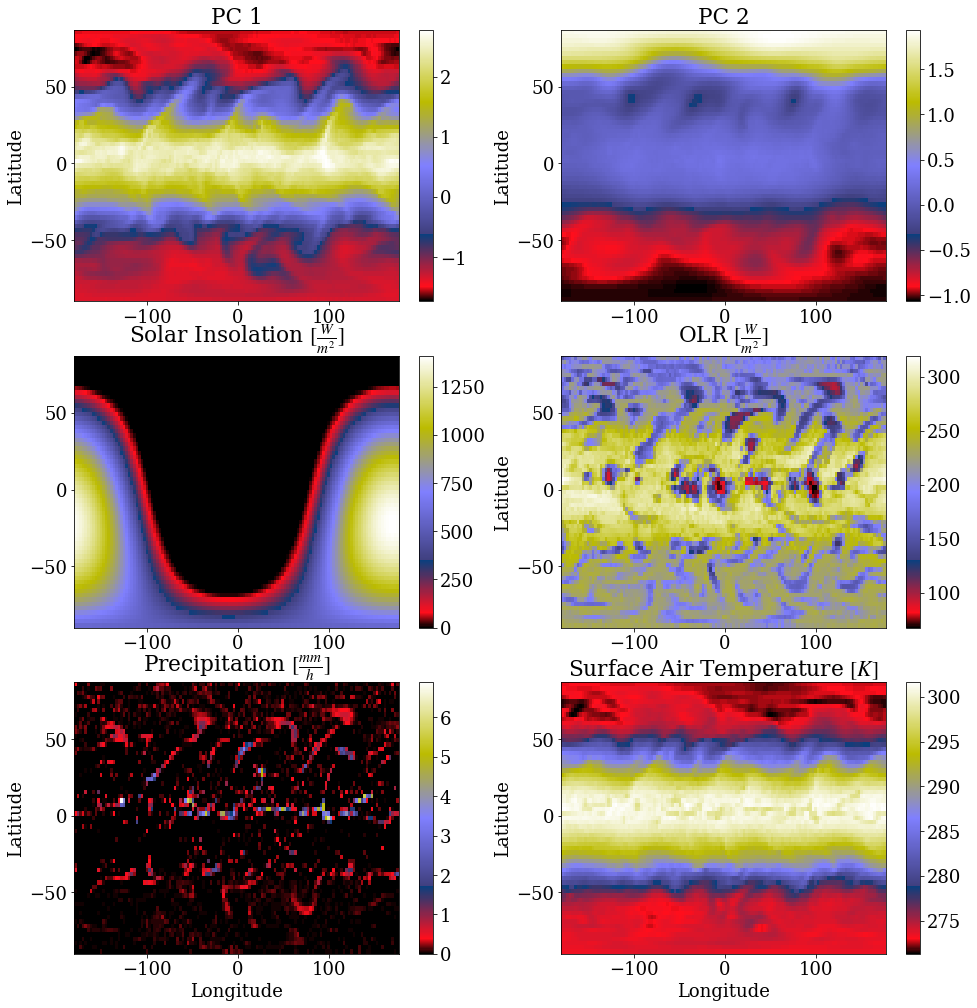

In [20]:
fig = plt.figure(4,(16,17))
plt.subplot(3,2,1)
imag1=plt.pcolormesh(lon,lat,np.reshape(input_pca[:,0],(time,lat.size,lon.size))[25,:],cmap=plt.cm.gist_stern)
plt.colorbar(imag1)
plt.ylabel('Latitude')
plt.title('PC 1')

plt.subplot(3,2,2)
imag1=plt.pcolormesh(lon,lat,np.reshape(input_pca[:,1],(time,lat.size,lon.size))[25,:],cmap=plt.cm.gist_stern)
plt.colorbar(imag1)
plt.ylabel('Latitude')
plt.title('PC 2')

plt.subplot(3,2,3)
imag2=plt.pcolormesh(lon,lat,np.reshape(SOLIN_resh[:],(time,lat.size,lon.size))[25,:],cmap=plt.cm.gist_stern)
plt.colorbar(imag2)
plt.title('Solar Insolation '+r'$[\frac{W}{m^2}]$')



plt.subplot(3,2,4)
imag3=plt.pcolormesh(lon,lat,np.reshape(OLR_resh[:],(time,lat.size,lon.size))[25,:],cmap=plt.cm.gist_stern)
plt.colorbar(imag3)
plt.ylabel('Latitude')
plt.title('OLR '+r'$[\frac{W}{m^2}]$')



plt.subplot(3,2,5)
imag4=plt.pcolormesh(lon,lat,np.reshape(precip_[:]*3600*1000,(time,lat.size,lon.size))[25,:],cmap=plt.cm.gist_stern)
plt.colorbar(imag4)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Precipitation '+r'$[\frac{mm}{h}]$')


plt.subplot(3,2,6)
imag5=plt.pcolormesh(lon,lat,np.reshape(T_surf_[:],(time,lat.size,lon.size))[25,:],cmap=plt.cm.gist_stern)
plt.colorbar(imag5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Surface Air Temperature '+r'$[K]$')




<ipython-input-63-38740fbd3954>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  imag1=plt.pcolormesh(lon,lat,np.reshape(input_pca[:,1],(time,lat.size,lon.size))[25,:],cmap=plt.cm.gist_stern)
<ipython-input-63-38740fbd3954>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  imag2=plt.pcolormesh(lon,lat,np.reshape(SOLIN_resh[:],(time,lat.size,lon.size))[25,:],cmap=plt.cm.gist_stern)
<ipython-input-63-38740fbd3954>:16: MatplotlibDeprecationWarning: shading='flat

Text(0.5, 1.0, 'Surface Air Temperature $[K]$')

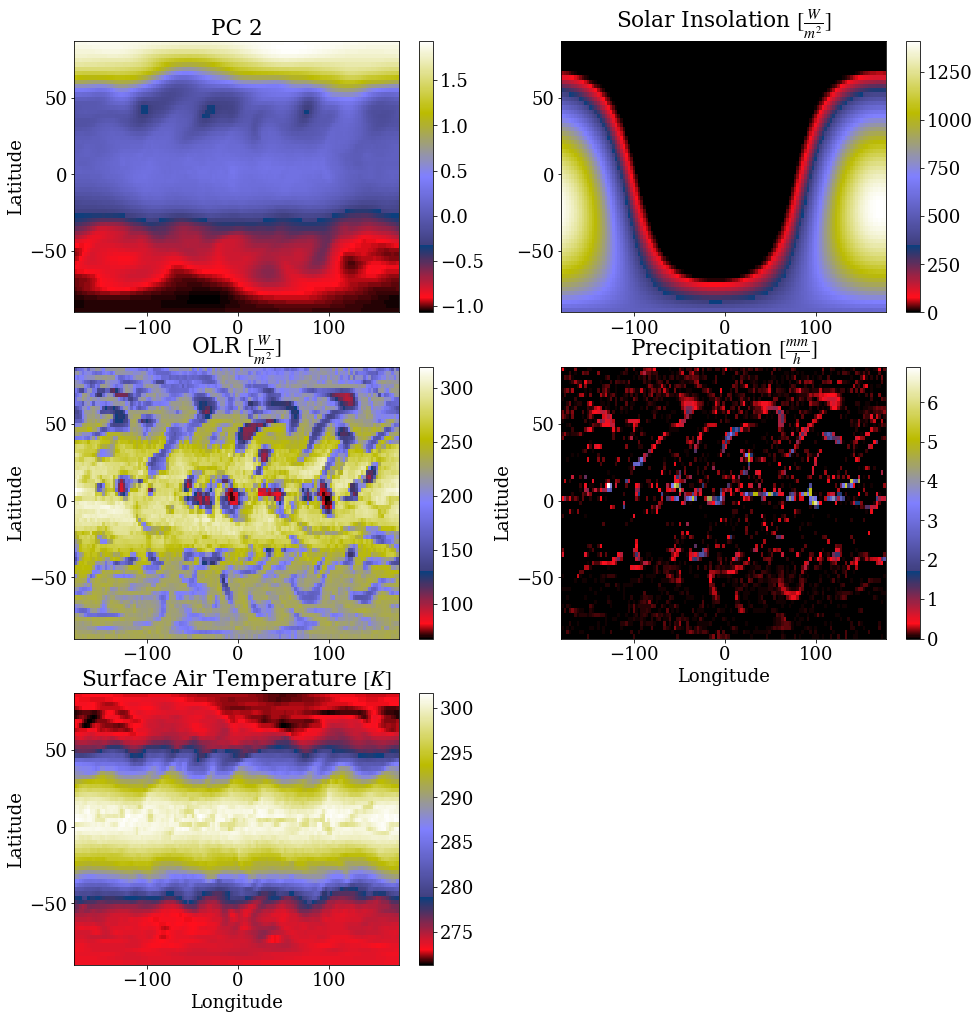

In [63]:
fig = plt.figure(4,(16,17))
plt.subplot(3,2,1)
imag1=plt.pcolormesh(lon,lat,np.reshape(input_pca[:,1],(time,lat.size,lon.size))[25,:],cmap=plt.cm.gist_stern)
plt.colorbar(imag1)
plt.ylabel('Latitude')
plt.title('PC 2')

plt.subplot(3,2,2)
imag2=plt.pcolormesh(lon,lat,np.reshape(SOLIN_resh[:],(time,lat.size,lon.size))[25,:],cmap=plt.cm.gist_stern)
plt.colorbar(imag2)
plt.title('Solar Insolation '+r'$[\frac{W}{m^2}]$')



plt.subplot(3,2,3)
imag3=plt.pcolormesh(lon,lat,np.reshape(OLR_resh[:],(time,lat.size,lon.size))[25,:],cmap=plt.cm.gist_stern)
plt.colorbar(imag3)
plt.ylabel('Latitude')
plt.title('OLR '+r'$[\frac{W}{m^2}]$')



plt.subplot(3,2,4)
imag4=plt.pcolormesh(lon,lat,np.reshape(precip_[:]*3600*1000,(time,lat.size,lon.size))[25,:],cmap=plt.cm.gist_stern)
plt.colorbar(imag4)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Precipitation '+r'$[\frac{mm}{h}]$')


plt.subplot(3,2,5)
imag5=plt.pcolormesh(lon,lat,np.reshape(T_surf_[:],(time,lat.size,lon.size))[25,:],cmap=plt.cm.gist_stern)
plt.colorbar(imag5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Surface Air Temperature '+r'$[K]$')




<ipython-input-21-bfa275e06ad3>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  imag1=plt.pcolormesh(lon,lat,np.reshape(input_pca[:,0],(time,lat.size,lon.size))[50,:],cmap=plt.cm.gist_stern)
<ipython-input-21-bfa275e06ad3>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  imag1=plt.pcolormesh(lon,lat,np.reshape(input_pca[:,1],(time,lat.size,lon.size))[50,:],cmap=plt.cm.gist_stern)
<ipython-input-21-bfa275e06ad3>:15: MatplotlibDeprecationWarning: shading='fla

Text(0.5, 1.0, 'Surface Air Temperature $[K]$')

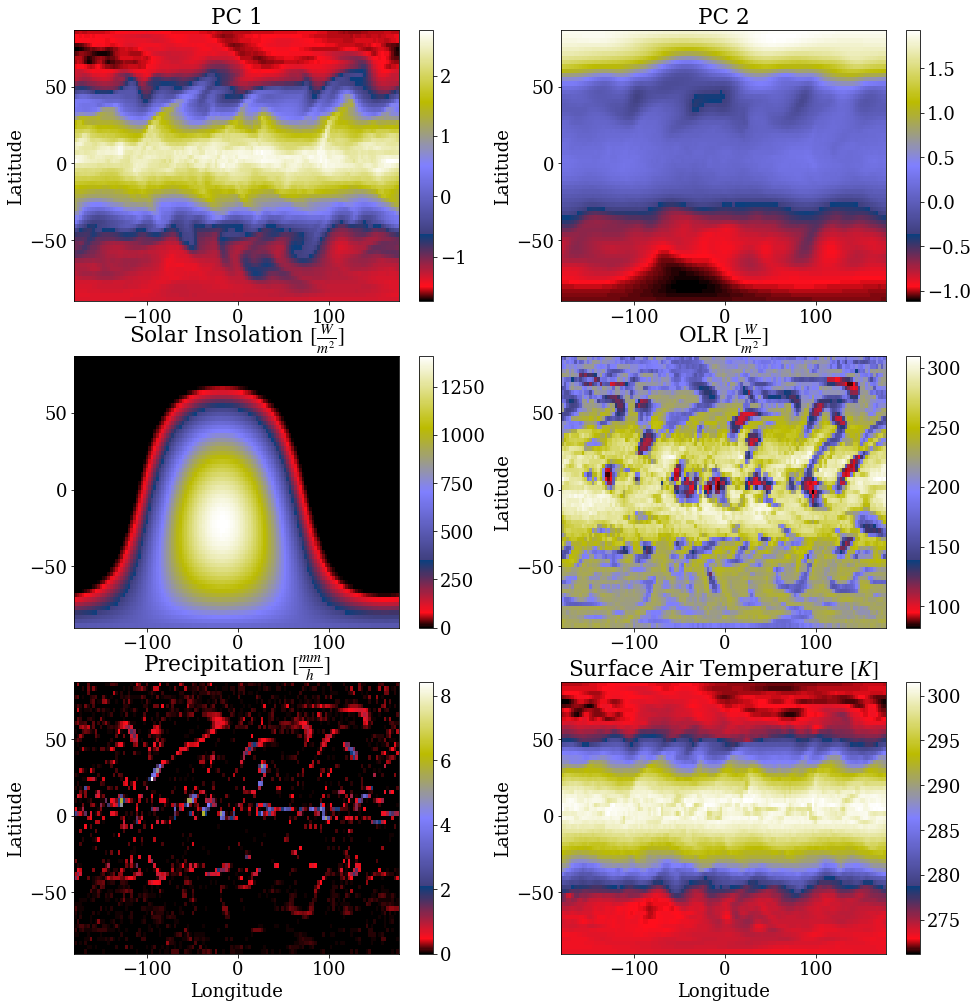

In [21]:
fig = plt.figure(4,(16,17))
plt.subplot(3,2,1)
imag1=plt.pcolormesh(lon,lat,np.reshape(input_pca[:,0],(time,lat.size,lon.size))[50,:],cmap=plt.cm.gist_stern)
plt.colorbar(imag1)
plt.ylabel('Latitude')
plt.title('PC 1')

plt.subplot(3,2,2)
imag1=plt.pcolormesh(lon,lat,np.reshape(input_pca[:,1],(time,lat.size,lon.size))[50,:],cmap=plt.cm.gist_stern)
plt.colorbar(imag1)
plt.ylabel('Latitude')
plt.title('PC 2')

plt.subplot(3,2,3)
imag2=plt.pcolormesh(lon,lat,np.reshape(SOLIN_resh[:],(time,lat.size,lon.size))[50,:],cmap=plt.cm.gist_stern)
plt.colorbar(imag2)
plt.title('Solar Insolation '+r'$[\frac{W}{m^2}]$')



plt.subplot(3,2,4)
imag3=plt.pcolormesh(lon,lat,np.reshape(OLR_resh[:],(time,lat.size,lon.size))[50,:],cmap=plt.cm.gist_stern)
plt.colorbar(imag3)
plt.ylabel('Latitude')
plt.title('OLR '+r'$[\frac{W}{m^2}]$')



plt.subplot(3,2,5)
imag4=plt.pcolormesh(lon,lat,np.reshape(precip_[:]*3600*1000,(time,lat.size,lon.size))[50,:],cmap=plt.cm.gist_stern)
plt.colorbar(imag4)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Precipitation '+r'$[\frac{mm}{h}]$')


plt.subplot(3,2,6)
imag5=plt.pcolormesh(lon,lat,np.reshape(T_surf_[:],(time,lat.size,lon.size))[50,:],cmap=plt.cm.gist_stern)
plt.colorbar(imag5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Surface Air Temperature '+r'$[K]$')




<ipython-input-65-a88570c1e806>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  imag1=plt.pcolormesh(lon,lat,np.reshape(input_pca[:,1],(time,lat.size,lon.size))[50,:],cmap=plt.cm.gist_stern)
<ipython-input-65-a88570c1e806>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  imag2=plt.pcolormesh(lon,lat,np.reshape(SOLIN_resh[:],(time,lat.size,lon.size))[50,:],cmap=plt.cm.gist_stern)
<ipython-input-65-a88570c1e806>:16: MatplotlibDeprecationWarning: shading='flat

Text(0.5, 1.0, 'Surface Air Temperature $[K]$')

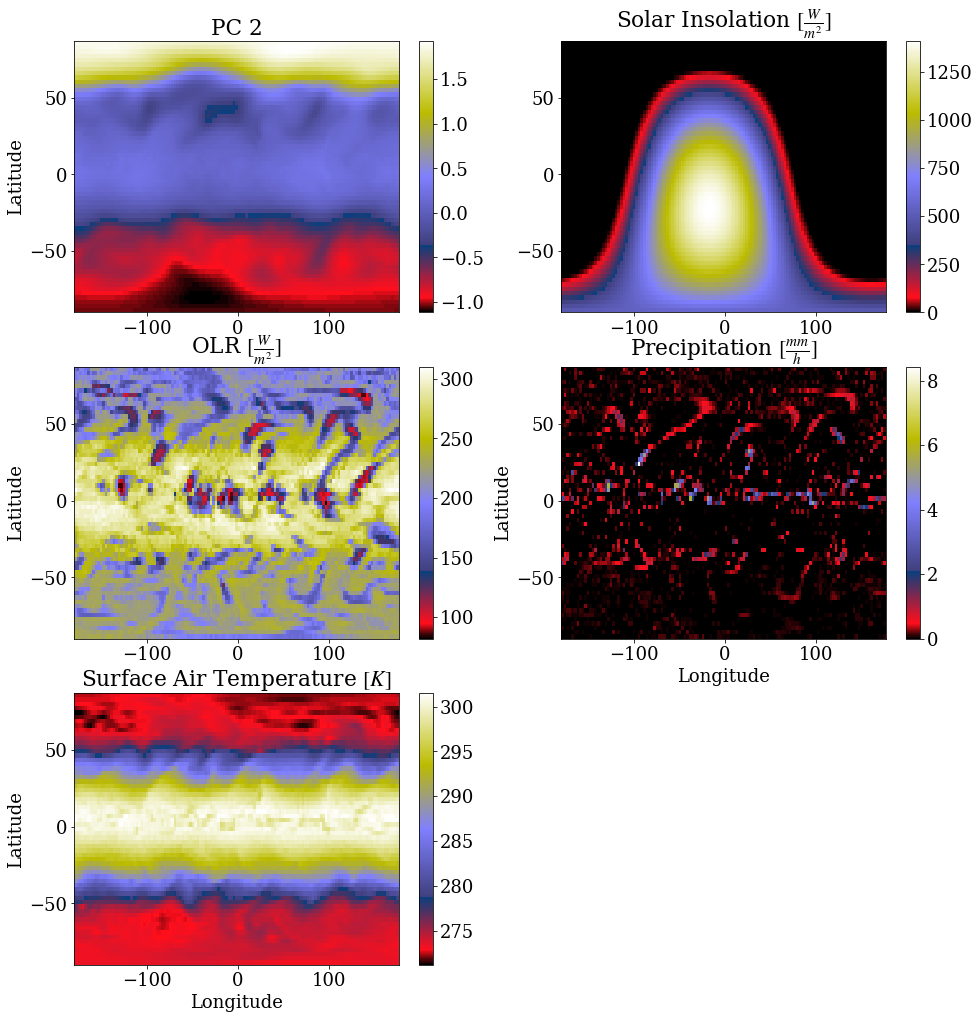

In [65]:
fig = plt.figure(4,(16,17))
plt.subplot(3,2,1)
imag1=plt.pcolormesh(lon,lat,np.reshape(input_pca[:,1],(time,lat.size,lon.size))[50,:],cmap=plt.cm.gist_stern)
plt.colorbar(imag1)
plt.ylabel('Latitude')
plt.title('PC 2')

plt.subplot(3,2,2)
imag2=plt.pcolormesh(lon,lat,np.reshape(SOLIN_resh[:],(time,lat.size,lon.size))[50,:],cmap=plt.cm.gist_stern)
plt.colorbar(imag2)
plt.title('Solar Insolation '+r'$[\frac{W}{m^2}]$')



plt.subplot(3,2,3)
imag3=plt.pcolormesh(lon,lat,np.reshape(OLR_resh[:],(time,lat.size,lon.size))[50,:],cmap=plt.cm.gist_stern)
plt.colorbar(imag3)
plt.ylabel('Latitude')
plt.title('OLR '+r'$[\frac{W}{m^2}]$')



plt.subplot(3,2,4)
imag4=plt.pcolormesh(lon,lat,np.reshape(precip_[:]*3600*1000,(time,lat.size,lon.size))[50,:],cmap=plt.cm.gist_stern)
plt.colorbar(imag4)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Precipitation '+r'$[\frac{mm}{h}]$')


plt.subplot(3,2,5)
imag5=plt.pcolormesh(lon,lat,np.reshape(T_surf_[:],(time,lat.size,lon.size))[50,:],cmap=plt.cm.gist_stern)
plt.colorbar(imag5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Surface Air Temperature '+r'$[K]$')


